<a href="https://colab.research.google.com/github/marioTavFer/somePython/blob/main/TransferLearning_KerasV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importar bibliotecas
import numpy as np
import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# carregando dataset (cats_vs_dogs) usando TFDS do tensorflow
# usando 40% para treinamento; 10% validação e 10% teste
tfds.disable_progress_bar()

treino_ds, valida_ds, teste_ds = tfds.load(
    "cats_vs_dogs",
    # reserva 10% para validação e 10% para teste
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # inclui rótulos (labels)
)

print(f"numero de dados para treinamento: {treino_ds.cardinality()}")
print(f"numero de dados para validação: {valida_ds.cardinality()}")
print(f"numero de dados para teste: {teste_ds.cardinality()}")

numero de dados para treinamento: 9305
numero de dados para validação: 2326
numero de dados para teste: 2326


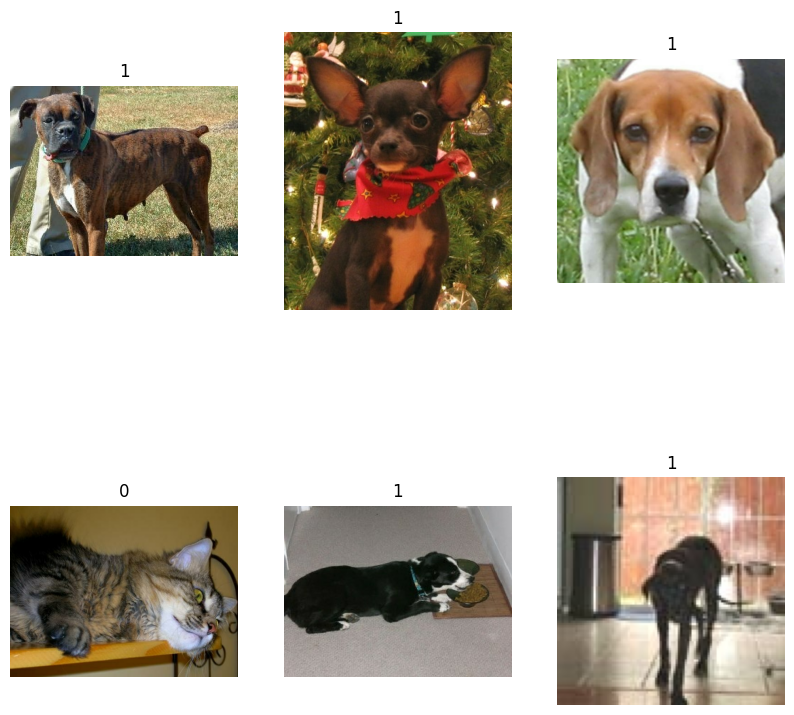

In [ ]:
# mostra 6 imagens do dataset (2x3)
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(treino_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
# padronizando as imagens (150x150)
resize_fn = keras.layers.Resizing(150, 150)

treino_ds = treino_ds.map(lambda x, y: (resize_fn(x), y))
valida_ds = valida_ds.map(lambda x, y: (resize_fn(x), y))
teste_ds = teste_ds.map(lambda x, y: (resize_fn(x), y))

In [ ]:
# opcional - em comentário
# para 'criar' novas imagens usando 'augmentation'
# é interessante quando dataset pequeno e/ou diminuir overfitting
#no caso, cats_vs_dogs tem 25.000 imagens

#augmentation_layers = [
#    layers.RandomFlip("horizontal"),
#    layers.RandomRotation(0.1),
#]
#
#def data_augmentation(x):
#    for layer in augmentation_layers:
#        x = layer(x)
#    return x
#
#treino_ds = treino_ds.map(lambda x, y: (data_augmentation(x), y))


In [ ]:
# para tornar o processo anterior mais rápido, usar batch, prefeching para otimizar carga de dados
# precisa ter os dados em batch senão dá problema quando criar modelo
from tensorflow import data as tf_data

batch_size = 64

treino_ds = treino_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
valida_ds = valida_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
teste_ds = teste_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [ ]:
# visualizar resultado da rotação de imagens
#for images, labels in treino_ds.take(1):
#    plt.figure(figsize=(10, 10))
#    first_image = images[0]
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
#        plt.imshow(np.array(augmented_image[0]).astype("int32"))
#        plt.title(int(labels[0]))
#        plt.axis("off")

In [ ]:
#construir um modelo pegando os pesos de modelo já treinado em imagenet
# com Xception
modelo_base = keras.applications.Xception(
    weights="imagenet",  # carga dos pesos pré-treinados da imagenet.
    input_shape=(150, 150, 3), # imagem 150x150 colorida (rgb)
    include_top=False,
)  # não inclue classificador da imagenet.

# congela modelo_base
modelo_base.trainable = False

# Ccria novo modelo
inputs = keras.Input(shape=(150, 150, 3))


# os pesos do medelo pré-treinado precisam ser colocados em
#escala de 0 a 255 para -1 a 1
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# o modelo_base tem camadas 'batchnormalization' que teem que ser mantidas.
# quando as camadas forem 'destravadas' para fazer otimização
x = modelo_base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
modelo_novo = keras.Model(inputs, outputs)

modelo_novo.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_11 (InputLayer)         │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_5 (Rescaling)             │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_4          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_4 (Dropout)                 │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_4 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# treinando camada superior
modelo_novo.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("ajustando o 'top layer' do modelo")
modelo_novo.fit(treino_ds, epochs=epochs, validation_data=valida_ds)

ajustando o 'top layer' do modelo
Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 57s 266ms/step - binary_accuracy: 0.8618 - loss: 0.2725 - val_binary_accuracy: 0.9660 - val_loss: 0.0907
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - binary_accuracy: 0.9678 - loss: 0.0847 - val_binary_accuracy: 0.9678 - val_loss: 0.0820


In [ ]:
# otimizando o modelo
# destravar o modelo_base, ele continua em 'modo de inferência' (pesos do batchnormalization', porque
# tinha sido usado 'training=False' quando foi 'chamado' (acima no código)
#isto previne mudanças das camadas de 'batchnormalization'
modelo_base.trainable = True
modelo_novo.summary(show_trainable=True)

modelo_novo.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # baixa taxa de aprendizado
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("ajustando modelo de 'ponta-a-ponta")
modelo_novo.fit(treino_ds, epochs=epochs, validation_data=valida_ds)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_11 (InputLayer)         │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_5 (Rescaling)             │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_4          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_4 (Dropout)                 │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_4 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

ajustando modelo de 'ponta-a-ponta
146/146 ━━━━━━━━━━━━━━━━━━━━ 139s 606ms/step - binary_accuracy: 0.8713 - loss: 0.3463 - val_binary_accuracy: 0.9574 - val_loss: 0.1187


In [ ]:
print("avaliação com o teste_ds")
teste_perda, teste_acuracia = modelo_novo.evaluate(teste_ds)
print ('Loss: ', teste_perda)
print ('Accuracy: ', teste_acuracia)

avaliação com o teste_ds
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - binary_accuracy: 0.9560 - loss: 0.1072
Loss:  0.1180233359336853
Accuracy:  0.9535683393478394
